In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

In [2]:
# Classification Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
dfb = pd.read_csv('FantasyPros_Fantasy_Football_Advanced_Stats_Report_WR.csv')

In [4]:
dfb.head()

,Rank,Player,G,REC,YDS,Y/R,YBC,YBC/R,AIR,AIR/R,...,% TM,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG
0,1.0,Davante Adams (GB),14.0,115.0,"1,374",11.9,777,6.8,777,6.8,...,29.7%,116.0,1.0,28.0,49.0,18.0,10.0,5.0,1.0,56.0
1,2.0,Tyreek Hill (KC),15.0,87.0,"1,276",14.7,842,9.7,842,9.7,...,22.1%,94.0,5.0,17.0,49.0,20.0,11.0,5.0,2.0,75.0
2,3.0,Stefon Diggs (BUF),16.0,127.0,"1,535",12.1,"1,071",8.4,"1,071",8.4,...,29.0%,137.0,8.0,16.0,62.0,20.0,5.0,5.0,2.0,55.0
3,4.0,Calvin Ridley (ATL),15.0,90.0,"1,374",15.3,"1,099",12.2,"1,099",12.2,...,23.6%,96.0,6.0,20.0,58.0,23.0,8.0,3.0,2.0,63.0
4,5.0,D.K. Metcalf (SEA),16.0,83.0,"1,303",15.7,940,11.3,940,11.3,...,24.0%,92.0,8.0,16.0,50.0,17.0,12.0,5.0,3.0,62.0


We are looking at advanced statistics we must get rid of some of the more basic statistics. Specifically receptions, games, targets, and yards.

In [5]:
display(dfb.columns)

Index(['Rank', 'Player', 'G', 'REC', 'YDS', 'Y/R', 'YBC', 'YBC/R', 'AIR',
       'AIR/R', 'YAC', 'YAC/R', 'YACON', 'YACON/R', 'BRKTKL', 'TGT', '% TM',
       'CATCHABLE', 'DROP', 'RZ TGT', '10+ YDS', '20+ YDS', '30+ YDS',
       '40+ YDS', '50+ YDS', 'LNG'],
      dtype='object')

In [6]:
dfb = dfb[['Rank', 'Player', 'Y/R', 'YBC', 'YBC/R', 'AIR',
       'AIR/R', 'YAC', 'YAC/R', 'YACON', 'YACON/R', 'BRKTKL', '% TM',
       'CATCHABLE', 'DROP', 'RZ TGT', '10+ YDS', '20+ YDS', '30+ YDS',
       '40+ YDS', '50+ YDS', 'LNG']]

In [7]:
dfb['% TM'] = dfb['% TM'].str.rstrip('%').astype('float') / 100.0

In [8]:
corr = dfb.corr()
corr['Rank'].nsmallest(6)

10+ YDS     -0.920567
% TM        -0.917860
CATCHABLE   -0.915263
20+ YDS     -0.879548
YAC         -0.861921
RZ TGT      -0.853427
Name: Rank, dtype: float64

Because the better the rank the smaller the number, we must look at the smallest rather than largest correlation.

In [9]:
df = dfb.dropna()
df.isna().sum()

Rank         0
Player       0
Y/R          0
YBC          0
YBC/R        0
AIR          0
AIR/R        0
YAC          0
YAC/R        0
YACON        0
YACON/R      0
BRKTKL       0
% TM         0
CATCHABLE    0
DROP         0
RZ TGT       0
10+ YDS      0
20+ YDS      0
30+ YDS      0
40+ YDS      0
50+ YDS      0
LNG          0
dtype: int64

I need to create a variable where I can test my accuracy so I will create a new column named top 50 and use different regression models to test the accuracy of the variables I have chosen. Some of the models require a value to only be 2 different options.

In [10]:
df['Top_50'] = np.where(df['Rank'] < 51, 1, 0)

<ipython-input-10-1d8042931f34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Top_50'] = np.where(df['Rank'] < 51, 1, 0)


In [11]:
display(df.head(2))
display(df.tail(2))

,Rank,Player,Y/R,YBC,YBC/R,AIR,AIR/R,YAC,YAC/R,YACON,...,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG,Top_50
0,1.0,Davante Adams (GB),11.9,777,6.8,777,6.8,597.0,5.2,152.0,...,116.0,1.0,28.0,49.0,18.0,10.0,5.0,1.0,56.0,1
1,2.0,Tyreek Hill (KC),14.7,842,9.7,842,9.7,434.0,5.0,118.0,...,94.0,5.0,17.0,49.0,20.0,11.0,5.0,2.0,75.0,1


,Rank,Player,Y/R,YBC,YBC/R,AIR,AIR/R,YAC,YAC/R,YACON,...,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG,Top_50
197,198.0,Tavon Austin (JAC),4.0,-22,-4.4,-22,-4.4,42.0,8.4,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0
198,199.0,Andre Roberts (LAC),8.5,29,7.3,29,7.3,5.0,1.3,1.0,...,5.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,16.0,0


I created the variable top 50 so I can test my accuracy, as you can see from the data frames head and tail, the column Top 50 is yes when the the player has a rank above 51.

In [12]:
x = df[['10+ YDS', '% TM', 'CATCHABLE', '20+ YDS', 'YAC', 'RZ TGT']]
y = df[['Top_50']]

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.20, random_state = 5)

In [14]:
lr = sm.Logit(ytrain, sm.add_constant(xtrain)).fit()
lr_train = round(lr.predict(sm.add_constant(xtrain)))
lr_test = round(lr.predict(sm.add_constant(xtest)))
print()
print('Logistic Regression Accuracies:')
print('-------------------------------')
print()
print("LG Training Accuracy:")
print(metrics.accuracy_score(ytrain, lr_train))
print()
print("LG Testing Accuracy:")
print(metrics.accuracy_score(ytest, lr_test))

/Users/akashsetti/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


         Current function value: 0.000002
         Iterations: 35

Logistic Regression Accuracies:
-------------------------------

LG Training Accuracy:
1.0

LG Testing Accuracy:
0.875


/Users/akashsetti/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/akashsetti/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
dt_train = dt.predict(xtrain)
dt_test = dt.predict(xtest)
print('Decision Tree Accuracies:')
print('-------------------------')
print()
print("DT Training Accuracy:")
print(metrics.accuracy_score(ytrain, dt_train))
print()
print("DT Testing Accuracy:")
print(metrics.accuracy_score(ytest, dt_test))

Decision Tree Accuracies:
-------------------------

DT Training Accuracy:
1.0

DT Testing Accuracy:
0.875


In [16]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 20)
rf.fit(xtrain, ytrain)
rf_train = rf.predict(xtrain)
rf_test = rf.predict(xtest)
print('Random Forest Accuracies:')
print('-------------------------')
print()
print("RF Training Accuracy:")
print(metrics.accuracy_score(ytrain, rf_train))
print()
print("RF Testing Accuracy:")
print(metrics.accuracy_score(ytest, rf_test))

Random Forest Accuracies:
-------------------------

RF Training Accuracy:
1.0

RF Testing Accuracy:
0.9


<ipython-input-16-db19af4443ca>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(xtrain, ytrain)


Our random forest model seems to have the best accuracy for the testing data, so that will be the model that we use. I will print a confusion matrix for the training and testing for our random forest model to get a better understanding of the model.

<AxesSubplot:title={'center':'Training Data Confusion Matric Plot'}>

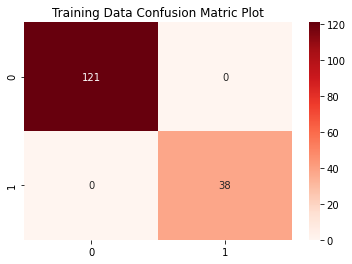

In [17]:
c_train = confusion_matrix(ytrain, rf_train)
c_test = confusion_matrix(ytest, rf_test)

plt.title("Training Data Confusion Matric Plot")
sns.heatmap(c_train, annot = True, fmt = '1', cmap = "Reds")

<AxesSubplot:title={'center':'Testing Data Confusion Matric Plot'}>

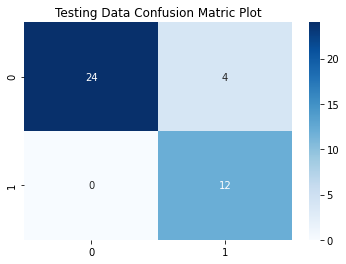

In [18]:
plt.title("Testing Data Confusion Matric Plot")
sns.heatmap(c_test, annot = True, fmt = '1', cmap = "Blues")

As the confusion matrix shows us for the testing data, we only had 4 false positives and 0 false negatives. 90% is a very effective number for using predictions, and focusing on these specific variables and using a random forest model proves to be an effective use of prediction.

I will also test for top 25 for reasons spoken on in the report.

In [19]:
df['Top_25'] = np.where(df['Rank'] < 26, 1, 0)

<ipython-input-19-92ef48a2ae7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Top_25'] = np.where(df['Rank'] < 26, 1, 0)


In [20]:
Y = df[["Top_25"]]

In [21]:
xtrn, xtst, ytrn, ytst = train_test_split(x, Y, test_size = 0.20, random_state = 5)

In [22]:
rf2 = RandomForestClassifier(n_estimators = 20, random_state = 20)
rf2.fit(xtrn, ytrn)
rf2_train = rf2.predict(xtrn)
rf2_test = rf2.predict(xtst)
print('Random Forest Accuracies(Top 25):')
print('-------------------------')
print()
print("RF Training Accuracy:")
print(metrics.accuracy_score(ytrn, rf2_train))
print()
print("RF Testing Accuracy:")
print(metrics.accuracy_score(ytst, rf2_test))

Random Forest Accuracies(Top 25):
-------------------------

RF Training Accuracy:
1.0

RF Testing Accuracy:
0.9


<ipython-input-22-19f3acfecfb7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(xtrn, ytrn)


<AxesSubplot:title={'center':'Training Data Confusion Matrix Plot(Top 25)'}>

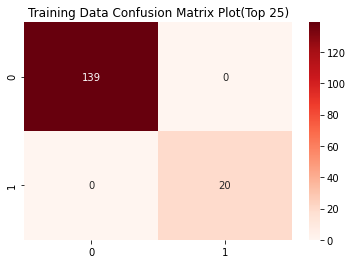

In [23]:
c_train2 = confusion_matrix(ytrn, rf2_train)
c_test2 = confusion_matrix(ytst, rf2_test)

plt.title("Training Data Confusion Matrix Plot(Top 25)")
sns.heatmap(c_train2, annot = True, fmt = '1', cmap = "Reds")

<AxesSubplot:title={'center':'Testing Data Confusion Matrix Plot(Top 25)'}>

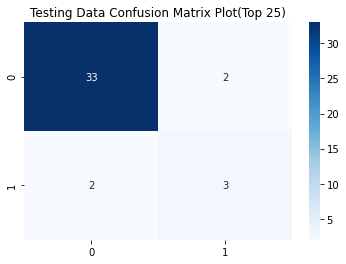

In [24]:
plt.title("Testing Data Confusion Matrix Plot(Top 25)")
sns.heatmap(c_test2, annot = True, fmt = '1', cmap = "Blues")

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.cluster import KMeans
lis = ['YBC', 'AIR']
    
    
df['YBC']=df['YBC'].str.replace(',','')
df['AIR']=df['AIR'].str.replace(',','')
    
df.drop(["Player"], axis = 1, inplace = True)

df.apply(pd.to_numeric)
km = KMeans(n_clusters = 4).fit(df)
y_km = km.predict(df)
clus = pd.DataFrame()
clus['data_index'] = df.index.values
clus['Cluster'] = km.labels_
dfb['Clusters'] = clus['Cluster']

<ipython-input-28-20e2d894d3ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YBC']=df['YBC'].str.replace(',','')
<ipython-input-28-20e2d894d3ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AIR']=df['AIR'].str.replace(',','')
/Users/akashsetti/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [30]:
def getPlayers(num):
    return display(dfb.Player.loc[dfb['Clusters'] == num])

getPlayers(0)

6                Adam Thielen (MIN)
12               Robert Woods (LAR)
13             Chase Claypool (PIT)
17               Keenan Allen (LAC)
19                CeeDee Lamb (DAL)
20              Nelson Agholor (NE)
21        JuJu Smith-Schuster (PIT)
23              Will Fuller V (MIA)
24              Curtis Samuel (WAS)
25            Diontae Johnson (PIT)
26             Robby Anderson (CAR)
27                Tee Higgins (CIN)
29                Chris Godwin (TB)
30               Cole Beasley (BUF)
31             Marquise Brown (BAL)
32               Brandon Aiyuk (SF)
33                Cooper Kupp (LAR)
34              Jarvis Landry (CLE)
35             Michael Gallup (DAL)
36                 Tyler Boyd (CIN)
37            Jamison Crowder (NYJ)
38                Tim Patrick (DEN)
39               Russell Gage (ATL)
40                T.Y. Hilton (IND)
41              Mike Williams (LAC)
42                Jerry Jeudy (DEN)
43    Marquez Valdes-Scantling (GB)
44           Emmanuel Sander

In [33]:
getPlayers(1)

66           Isaiah McKenzie (BUF)
96     Cordarrelle Patterson (ATL)
97               Deebo Samuel (SF)
111       Cedrick Wilson Jr. (DAL)
112            Andy Isabella (ARI)
                  ...             
194           Deontay Burnett (FA)
195                John Ross (NYG)
196         Bennie Fowler III (SF)
197             Tavon Austin (JAC)
198            Andre Roberts (LAC)
Name: Player, Length: 85, dtype: object

In [32]:
getPlayers(2)

0          Davante Adams (GB)
1            Tyreek Hill (KC)
2          Stefon Diggs (BUF)
3         Calvin Ridley (ATL)
4          D.K. Metcalf (SEA)
5      Justin Jefferson (MIN)
7             Mike Evans (TB)
8            A.J. Brown (TEN)
9       DeAndre Hopkins (ARI)
10        Tyler Lockett (SEA)
11    Allen Robinson II (CHI)
14     Marvin Jones Jr. (JAC)
15        Brandin Cooks (HOU)
16           D.J. Moore (CAR)
18         Amari Cooper (DAL)
22       Terry McLaurin (WAS)
28          Corey Davis (NYJ)
Name: Player, dtype: object

In [31]:
getPlayers(3)

49      Laviska Shenault Jr. (JAC)
56             Mecole Hardman (KC)
58               David Moore (DEN)
61                 Greg Ward (PHI)
63             Hunter Renfrow (LV)
65              Antonio Brown (TB)
67              Scotty Miller (TB)
68          James Washington (PIT)
69          Breshad Perriman (CHI)
70             Tre'Quan Smith (NO)
71              Jalen Guyton (LAC)
73               Allen Lazard (GB)
75          Odell Beckham Jr. (FA)
76                 John Brown (FA)
77          Demarcus Robinson (KC)
78               Randall Cobb (GB)
79           Willie Snead IV (CAR)
80            Danny Amendola (HOU)
81           Braxton Berrios (NYJ)
82                 KJ Hamler (DEN)
83            Anthony Miller (PIT)
84             Tyron Johnson (JAC)
85       Michael Pittman Jr. (IND)
86            Henry Ruggs III (FA)
87              Chris Conley (HOU)
88          Preston Williams (MIA)
89              Jalen Reagor (PHI)
90                  Cam Sims (WAS)
91               Kek

We are able to see the different clusters of different wide recievers. We see that the clusters are fairly similar to the player's rankings. However, there are some exceptions. This is important because we can see some players who are not highly being in the same catrgory as other highly rated and sucessful recievers. Being able to identify these breakout or bust(recievers that underperform than what was expected) recievers is what is one of the most important factors to fantasy football.